In [1]:
%matplotlib notebook
%pylab
import pandas as pd
from time import perf_counter

Using matplotlib backend: nbAgg
Populating the interactive namespace from numpy and matplotlib


In [2]:
# import dam break module
from dam_break_module_dg import * # for DG

In [3]:
# Dam break problem

def break_cases(case):

    
    if(case == 1):     #left going shock
        
        hl = 1
        hr = 1.5513875245483204
        ul = 0.5
        ur = 0

    elif(case == 2):  #right going shock
    
        hl = 1.5513875245483204
        hr = 1
        ul = 0.0
        ur = -0.5
    
    elif(case == 3):  #right going rarefaction
    
        hl = 0.5625
        hr = 1
        ul = 0
        ur = 0.5
    
    elif(case == 4):  #left going rarefaction
    
        hl = 2
        hr = 1.4571067811865475
        ul = 0
        ur = 0.41421356237309537
    
    elif(case == 5):
        
        hl = 2
        hr = 1

        ul = 0.0
        ur = 0
    
    return hl,hr,ul,ur

case = 4    # 1 = left going shock
            # 2 = right going shock
            # 3 = right going rarefaction
            # 4 = left going rarefaction
            # 5 = example

# Initial conditions
def h_init(x):
    
    hl,hr,ul,ur = break_cases(case)
    
    q0 = where(x < 0,hl,hr)
    
    return q0

def hu_init(x):    
    
    hl,hr,ul,ur = break_cases(case)
    
    q0 = where(x < 0,hl*ul,hr*ur)
    return q0

In [4]:
order = array([2])        # polynomial order
N_element = array([512])  # Good for N = 2, Ne = 512 and xmu = 0.1
kstages = 3
#CFL = 0.3                 # CFL number
Tfinal = 1
method_type = 'dg'
integration_type = 1      # % = 1 is inexact and = 2 is exact
iplot = False             # plot the solution
plot_movie = False
icase = 3                 # problem type: 1 = Gaussian, 2 = sinusoidal, 3 = dam break, ...
problem_type = 'Dam break problem'

delta_nl = 1
h_eps = 1e-3 
filter_type = 1
weight_type = 1   # 0 = quadratic, 1 = erfc-log
flux_type = 'roe' # rusa = rusanov, roe
xmu = 0.02        # filtering strength: 1 = full strength and 0 = no filter
ifilter = 1       # 1 = apply the filter, 0 = not apply the filter
limiter = 0       # 1 = apply the limiter, 0 = not apply the limiter

ax = -5            # left side of the problem domain       
bx = 5            # right side of the problem domain   
diss = 1
u = 2    

# initialize the norm arrays
len_el = len(N_element)
len_pol = len(order)
l2e_norm = zeros((len_pol, len_el))
max_norm = zeros((len_pol, len_el))

Nv = N_element
   
# Begining of the simulation
# loop over polynomial orders
for iN,N in enumerate(order):
    
    CFL = 1/(N+1)                 # CFL number
    
    # compute the number of node in each element
    if (integration_type == 1):
        Q = N
    elif (integration_type == 2):
        Q = N+1

    wall = 0
    
    # loop over elements
    for e, nel in enumerate(Nv):
        
        if (method_type == 'cg'):
            Np = nel*N + 1
        elif (method_type == 'dg'):
            Np = nel*(N+1)
    
        # Call dam break solver
        '''
        outputs:
        --------
        q_h, q_hu : height and momentum
        x_sol     : Global grids points
        coord     : All grid points
        intma     : Intma(CG/DG)
        '''
        tic = perf_counter()
        
    
        q_h,q_hu, x_sol, coord, intma = cg_dgSolver(N,Q,nel, Np, ax, bx, integration_type,\
        u, CFL,Tfinal, kstages, icase, delta_nl,h_eps,plot_movie,h_init,hu_init,xmu,ifilter,diss,\
                        method_type,limiter,filter_type,weight_type,flux_type)
        
        toc = perf_counter()
        wall += toc - tic
        
print('walltime = {:e}'.format(wall))

N = 2, nel = 512, Np = 1536
	dt = 1.0858e-03
	Number of time steps = 921
walltime = 1.003075e+02


In [5]:
meqn = 2  # Number of equations in the system

# Gravity
g = 1

# Temporal domain
to = 0

#Initial uo and ho for the newton method
ho = 0.1
uo = 0.01

# Numerical parameters
epislon = 1e-16
max_iter = 100

#Numerical values
qo = array([ho,uo])

#intial data
hl,hr,ul,ur = break_cases(case)
ql = array([hl,hl*ul])
qr = array([hr,hr*ur])

In [6]:
# call of the exact solution module
from exact_rp import *

#rarefaction solution
hmr,umr = rare(ql,qr,g)

#shock solution
hms,hums = newton(ql,qr,g)

ums = hums/hms

#intermediate states
qmr = array([hmr,hmr*umr])
qms = array([hms,hms*ums])

shock_speed = sr(hms,qr,g)

laml = lam1(hl,ul,g)
lamr = lam1(hmr,umr,g)

In [7]:
# Exact solution
mq = 0
qeh = qexact(x_sol,Tfinal,mq,ql,qr,g)  # Height
mq = 1
qeU = qexact(x_sol,Tfinal,mq,ql,qr,g)  # Momentum

<IPython.core.display.Javascript object>


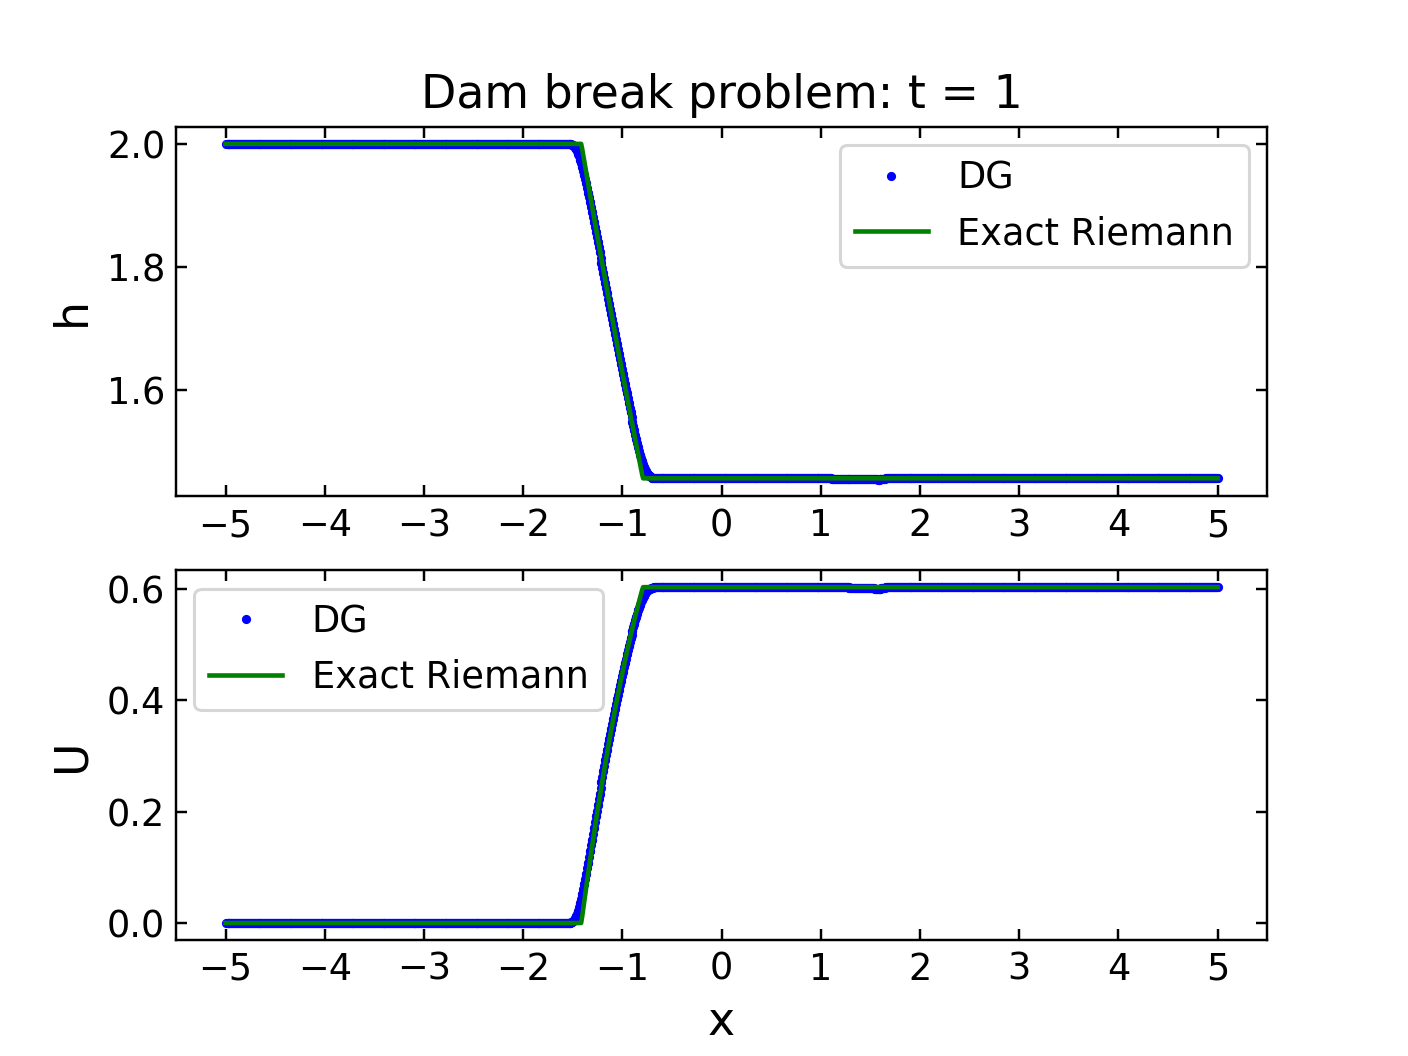

In [9]:
rcParams.update({'font.size': 12})
axi = arange(ax,bx+1)
figure(5)

ax1 = subplot(211)
plot(x_sol,q_h, 'bo',label = 'DG',markersize = 2)
plot(x_sol,qeh, 'g-',label = 'Exact Riemann')
ylabel('h', fontsize = 15)
xticks(axi)

ax1.tick_params(bottom = True, top = True, left = True, right = True)
ax1.tick_params(labelbottom = True, labeltop = False, labelleft = True, labelright = False)
ax1.tick_params(axis="x", direction="in")
ax1.tick_params(axis="y", direction="in")
legend()
title(problem_type +': t = {}'.format(Tfinal), fontsize = 15)


rcParams.update({'font.size': 12})
ax2 = subplot(212)
plot(x_sol,q_hu, 'bo',label = 'DG',markersize = 2)
plot(x_sol,qeU, 'g-',label = 'Exact Riemann')
xlabel('x', fontsize = 15)
ylabel('U', fontsize = 15)

xticks(axi)
ax2.tick_params(bottom = True, top = True, left = True, right=True)
ax2.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False)
ax2.tick_params(axis="x", direction="in")
ax2.tick_params(axis="y", direction="in")
legend()
show()